# Lesson 3: Sentence Window Retrieval

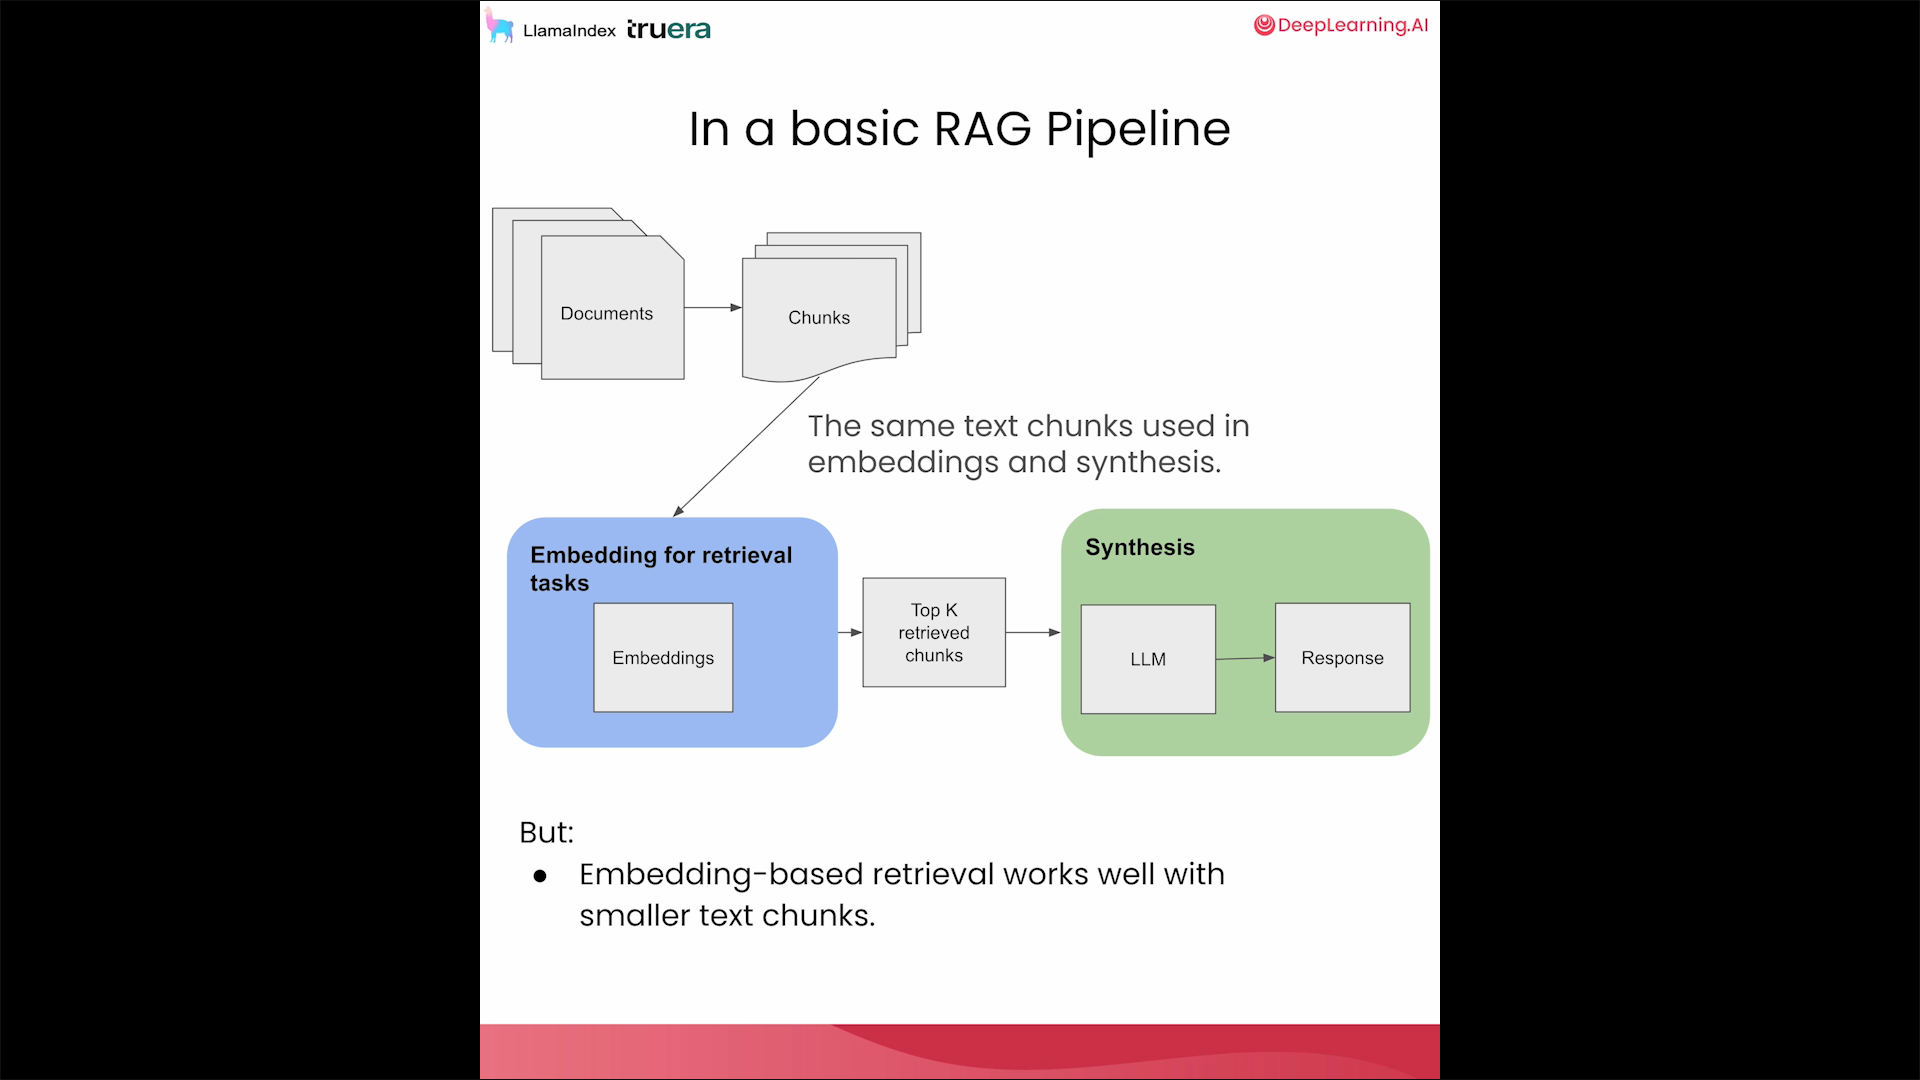

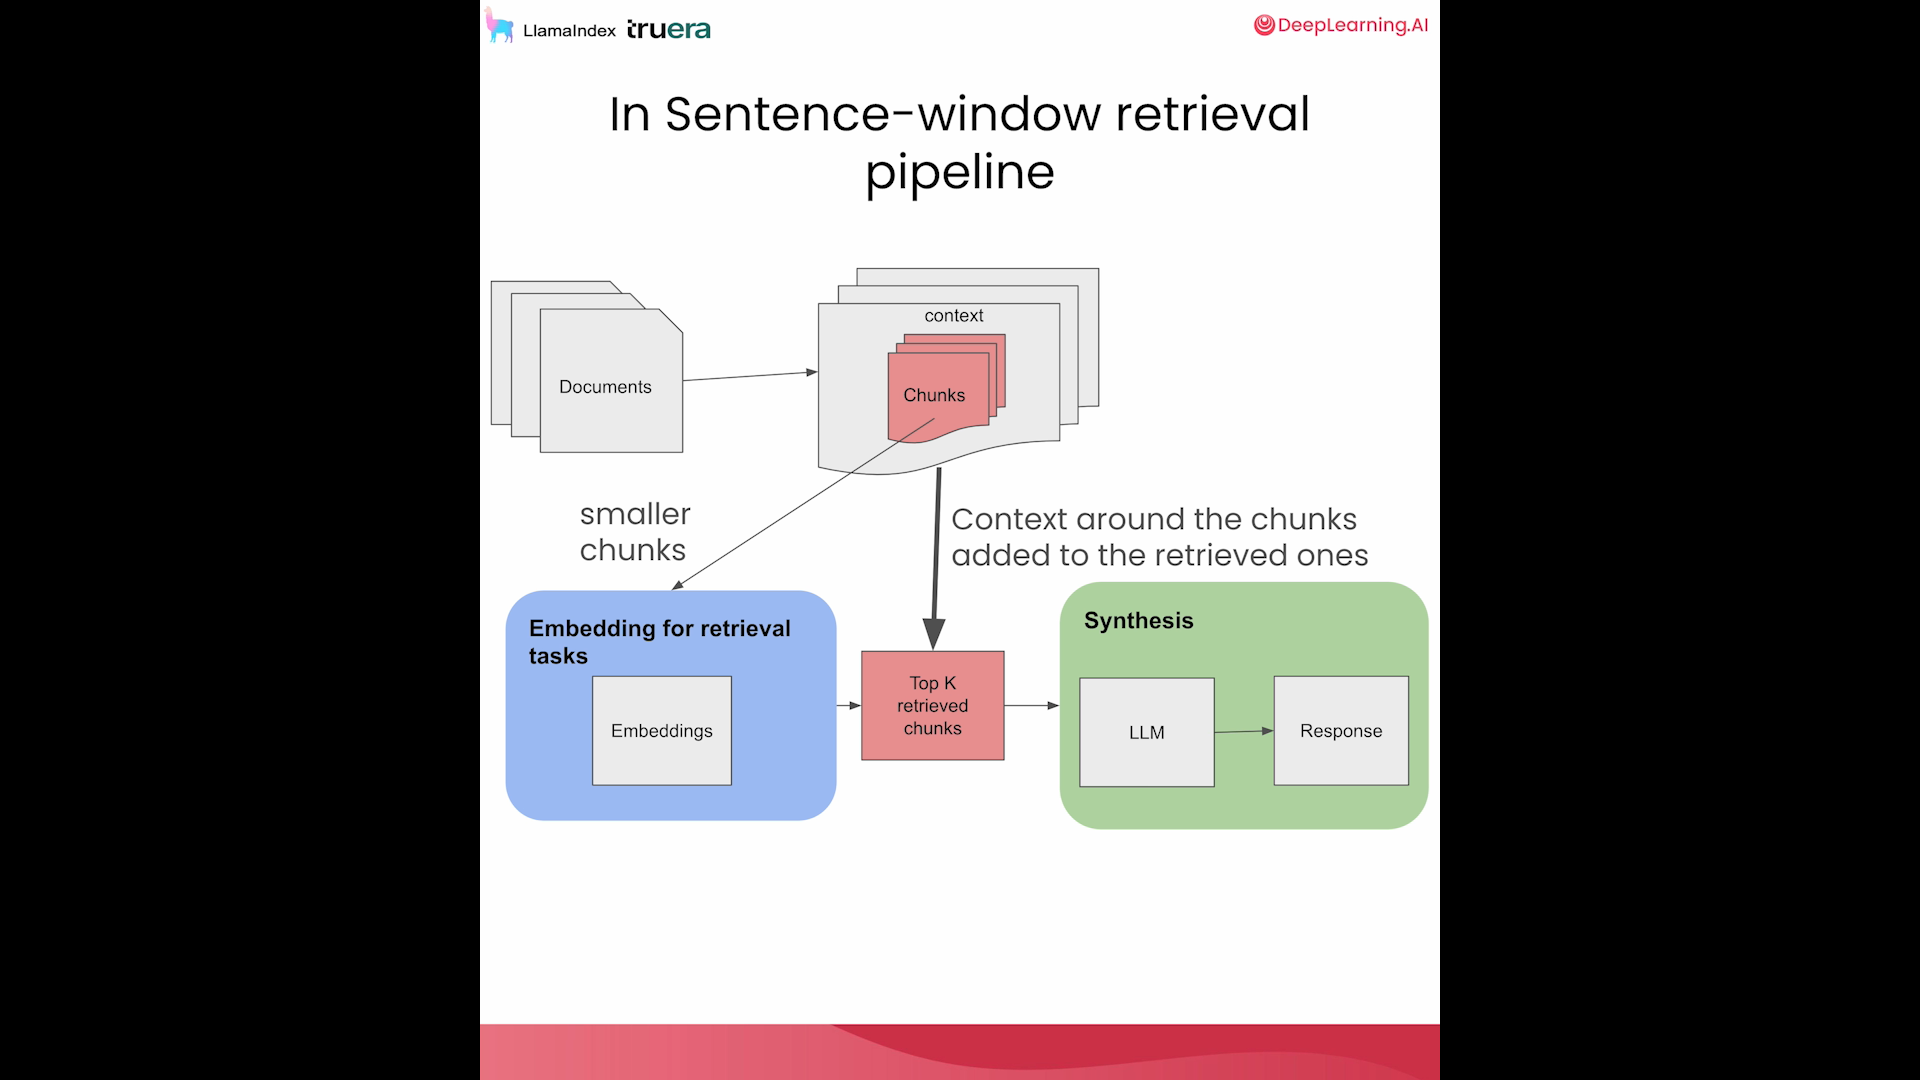

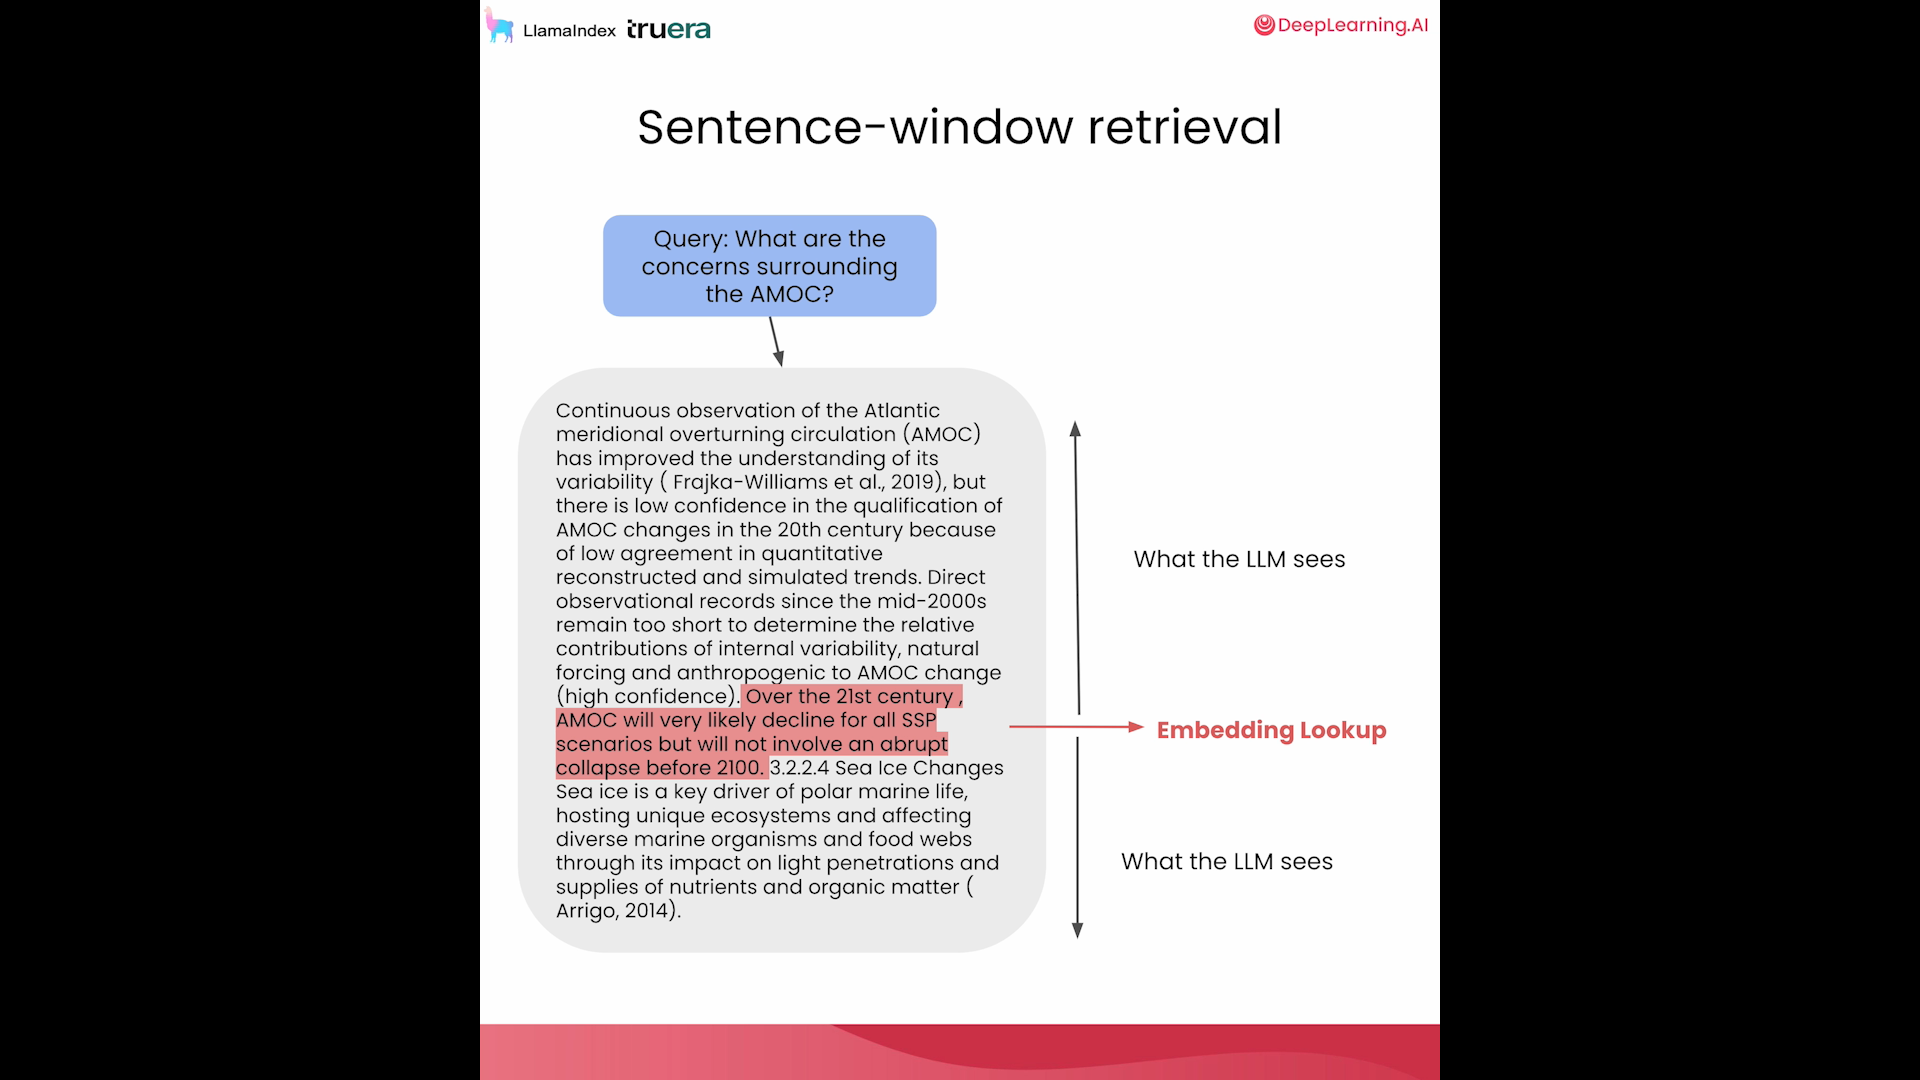

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import utils

import os
import openai
openai.api_key = utils.get_openai_api_key()

In [3]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files=["./eBook-How-to-Build-a-Career-in-AI.pdf"]
).load_data()

In [4]:
print(type(documents), "\n")
print(len(documents), "\n")
print(type(documents[0]))
print(documents[0])

<class 'list'> 

41 

<class 'llama_index.schema.Document'>
Doc ID: 00be6e98-a299-45dc-9974-7cec684c8d9f
Text: PAGE 1Founder, DeepLearning.AICollected Insights from Andrew Ng
How to  Build Your Career in AIA Simple Guide


In [5]:
from llama_index import Document

document = Document(text="\n\n".join([doc.text for doc in documents]))

## Window-sentence retrieval setup

In [6]:
from llama_index.node_parser import SentenceWindowNodeParser

# create the sentence window node parser w/ default settings
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
text = "hello. how are you? I am fine!  "

nodes = node_parser.get_nodes_from_documents([Document(text=text)])

In [23]:
print([x.text for x in nodes])

['hello. ', 'how are you? ', 'I am fine!  ']


In [24]:
print(nodes[1].metadata["window"]) ## For How are you .We are getting window of 3 sen . Before and After sen

hello.  how are you?  I am fine!  


In [10]:
text = "hello. foo bar. cat dog. mouse"

nodes = node_parser.get_nodes_from_documents([Document(text=text)])

In [11]:
print([x.text for x in nodes])

['hello. ', 'foo bar. ', 'cat dog. ', 'mouse']


In [12]:
print(nodes[0].metadata["window"])

hello.  foo bar.  cat dog. 


### Building the index

In [13]:
from llama_index.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

In [14]:
from llama_index import ServiceContext

sentence_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    # embed_model="local:BAAI/bge-large-en-v1.5"
    node_parser=node_parser,
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [15]:
from llama_index import VectorStoreIndex

sentence_index = VectorStoreIndex.from_documents(
    [document], service_context=sentence_context
)

In [16]:
sentence_index.storage_context.persist(persist_dir="./sentence_index")


In [ ]:
# This block of code is optional to check
# if an index file exist, then it will load it
# if not, it will rebuild it

import os
from llama_index import VectorStoreIndex, StorageContext, load_index_from_storage
from llama_index import load_index_from_storage

if not os.path.exists("./sentence_index"):
    sentence_index = VectorStoreIndex.from_documents(
        [document], service_context=sentence_context
    )

    sentence_index.storage_context.persist(persist_dir="./sentence_index")
else:
    sentence_index = load_index_from_storage(
        StorageContext.from_defaults(persist_dir="./sentence_index"),
        service_context=sentence_context
    )

### Building the postprocessor

MetadaReplacementPostProcessor - This takes values stored in metadata and replaces node text with that value . This is done after retrieving the nodes and before sending it to LLM

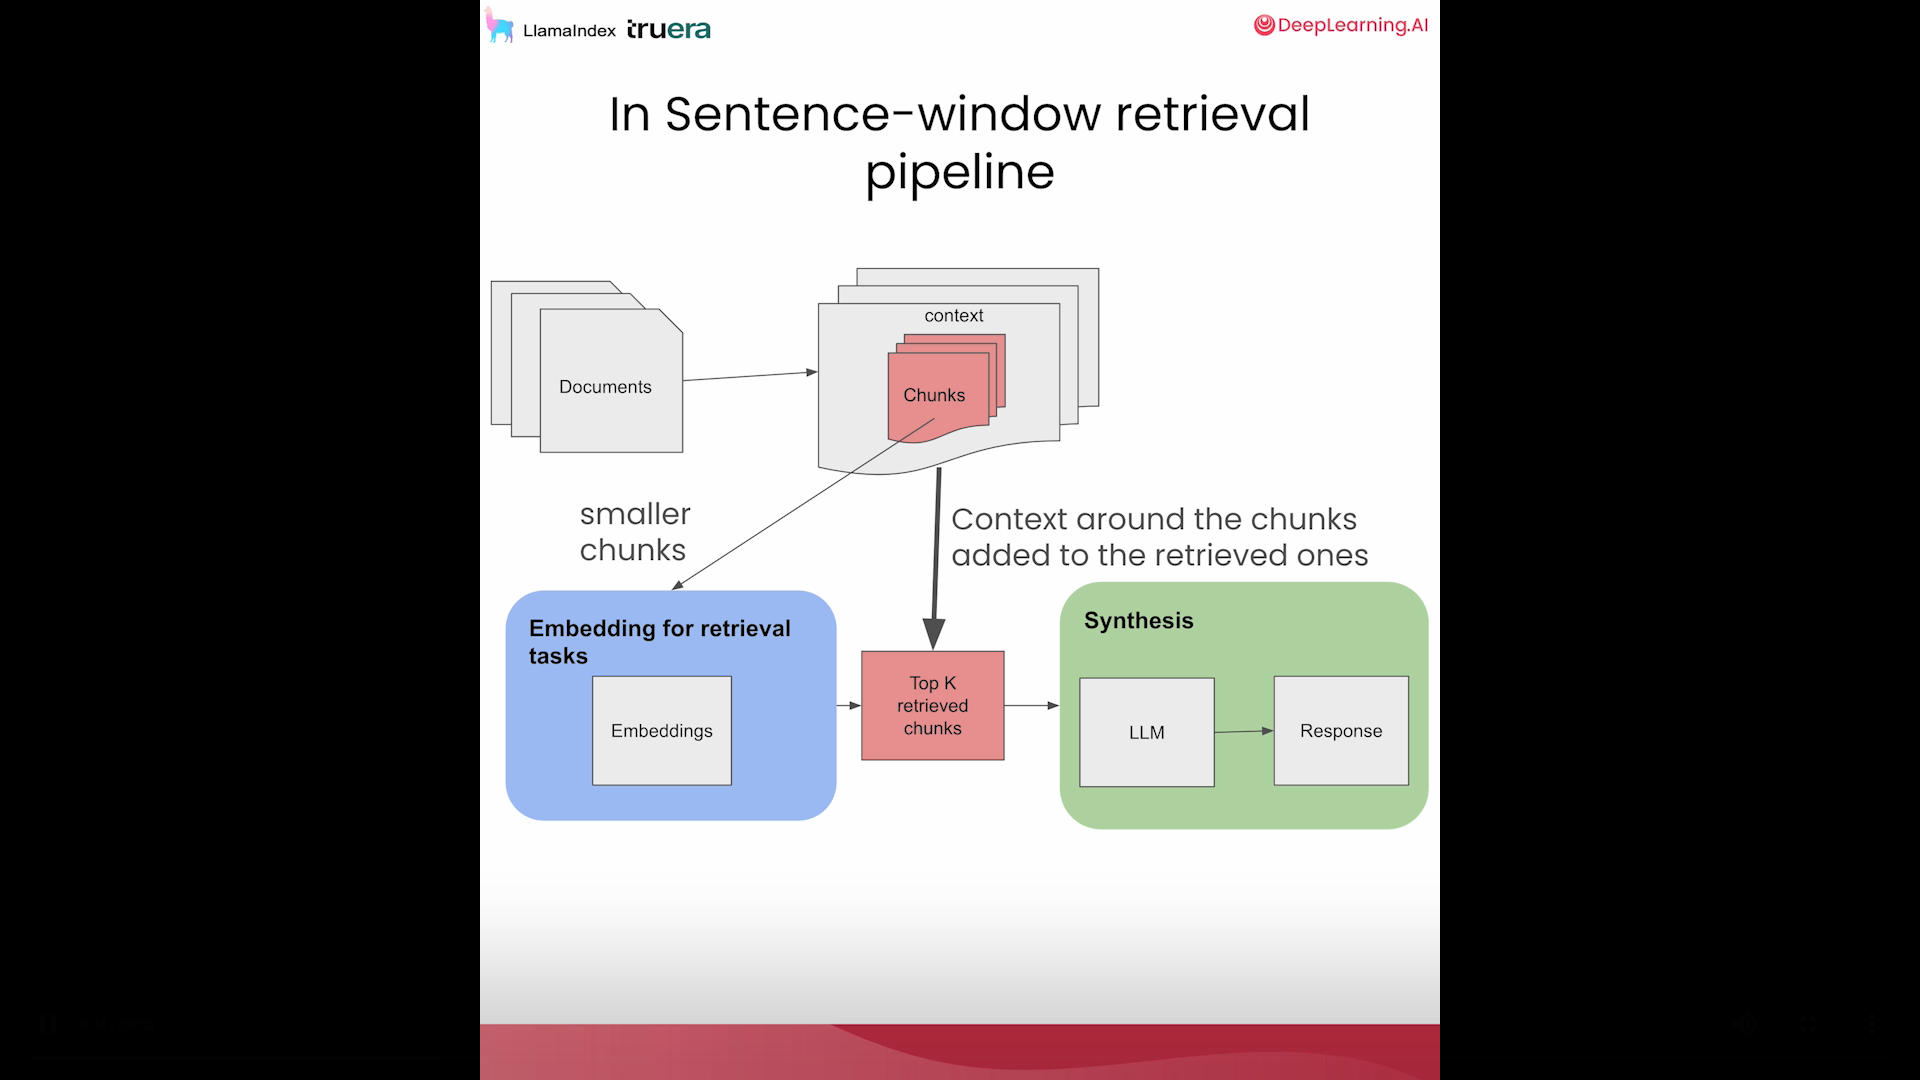

In [17]:
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor

postproc = MetadataReplacementPostProcessor(
    target_metadata_key="window"
)

In [18]:
from llama_index.schema import NodeWithScore
from copy import deepcopy

scored_nodes = [NodeWithScore(node=x, score=1.0) for x in nodes]
nodes_old = [deepcopy(n) for n in nodes]

In [25]:
nodes_old[1].text

'foo bar. '

In [26]:
replaced_nodes = postproc.postprocess_nodes(scored_nodes)

In [27]:
print(replaced_nodes[1].text)

hello.  foo bar.  cat dog.  mouse


### Adding a reranker

In [28]:
from llama_index.indices.postprocessor import SentenceTransformerRerank

# BAAI/bge-reranker-base
# link: https://huggingface.co/BAAI/bge-reranker-base
rerank = SentenceTransformerRerank(
    top_n=2, model="BAAI/bge-reranker-base"
)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

In [29]:
from llama_index import QueryBundle
from llama_index.schema import TextNode, NodeWithScore

query = QueryBundle("I want a dog.")

scored_nodes = [
    NodeWithScore(node=TextNode(text="This is a cat"), score=0.6),
    NodeWithScore(node=TextNode(text="This is a dog"), score=0.4),
]

In [30]:
reranked_nodes = rerank.postprocess_nodes(
    scored_nodes, query_bundle=query
)

In [31]:
print([(x.text, x.score) for x in reranked_nodes]) ## Sen with DOG has higher score

[('This is a dog', 0.91827345), ('This is a cat', 0.0014040739)]


### Runing the query engine

In [32]:
sentence_window_engine = sentence_index.as_query_engine(
    similarity_top_k=6, node_postprocessors=[postproc, rerank]
)

In [33]:
window_response = sentence_window_engine.query(
    "What are the keys to building a career in AI?"
)

In [34]:
from llama_index.response.notebook_utils import display_response

display_response(window_response)

**`Final Response:`** The keys to building a career in AI are learning foundational technical skills, working on projects, and finding a job, all of which is supported by being part of a community.

## Putting it all Together

In [35]:
import os
from llama_index import ServiceContext, VectorStoreIndex, StorageContext
from llama_index.node_parser import SentenceWindowNodeParser
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index import load_index_from_storage


def build_sentence_window_index(
    documents,
    llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    sentence_window_size=3,
    save_dir="sentence_index",
):
    # create the sentence window node parser w/ default settings
    node_parser = SentenceWindowNodeParser.from_defaults(
        window_size=sentence_window_size,
        window_metadata_key="window",
        original_text_metadata_key="original_text",
    )
    sentence_context = ServiceContext.from_defaults(
        llm=llm,
        embed_model=embed_model,
        node_parser=node_parser,
    )
    if not os.path.exists(save_dir):
        sentence_index = VectorStoreIndex.from_documents(
            documents, service_context=sentence_context
        )
        sentence_index.storage_context.persist(persist_dir=save_dir)
    else:
        sentence_index = load_index_from_storage(
            StorageContext.from_defaults(persist_dir=save_dir),
            service_context=sentence_context,
        )

    return sentence_index


def get_sentence_window_query_engine(
    sentence_index, similarity_top_k=6, rerank_top_n=2
):
    # define postprocessors
    postproc = MetadataReplacementPostProcessor(target_metadata_key="window")
    rerank = SentenceTransformerRerank(
        top_n=rerank_top_n, model="BAAI/bge-reranker-base"
    )

    sentence_window_engine = sentence_index.as_query_engine(
        similarity_top_k=similarity_top_k, node_postprocessors=[postproc, rerank]
    )
    return sentence_window_engine

In [36]:
from llama_index.llms import OpenAI

index = build_sentence_window_index(
    [document],
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    save_dir="./sentence_index",
)


In [37]:
query_engine = get_sentence_window_query_engine(index, similarity_top_k=6)


## TruLens Evaluation

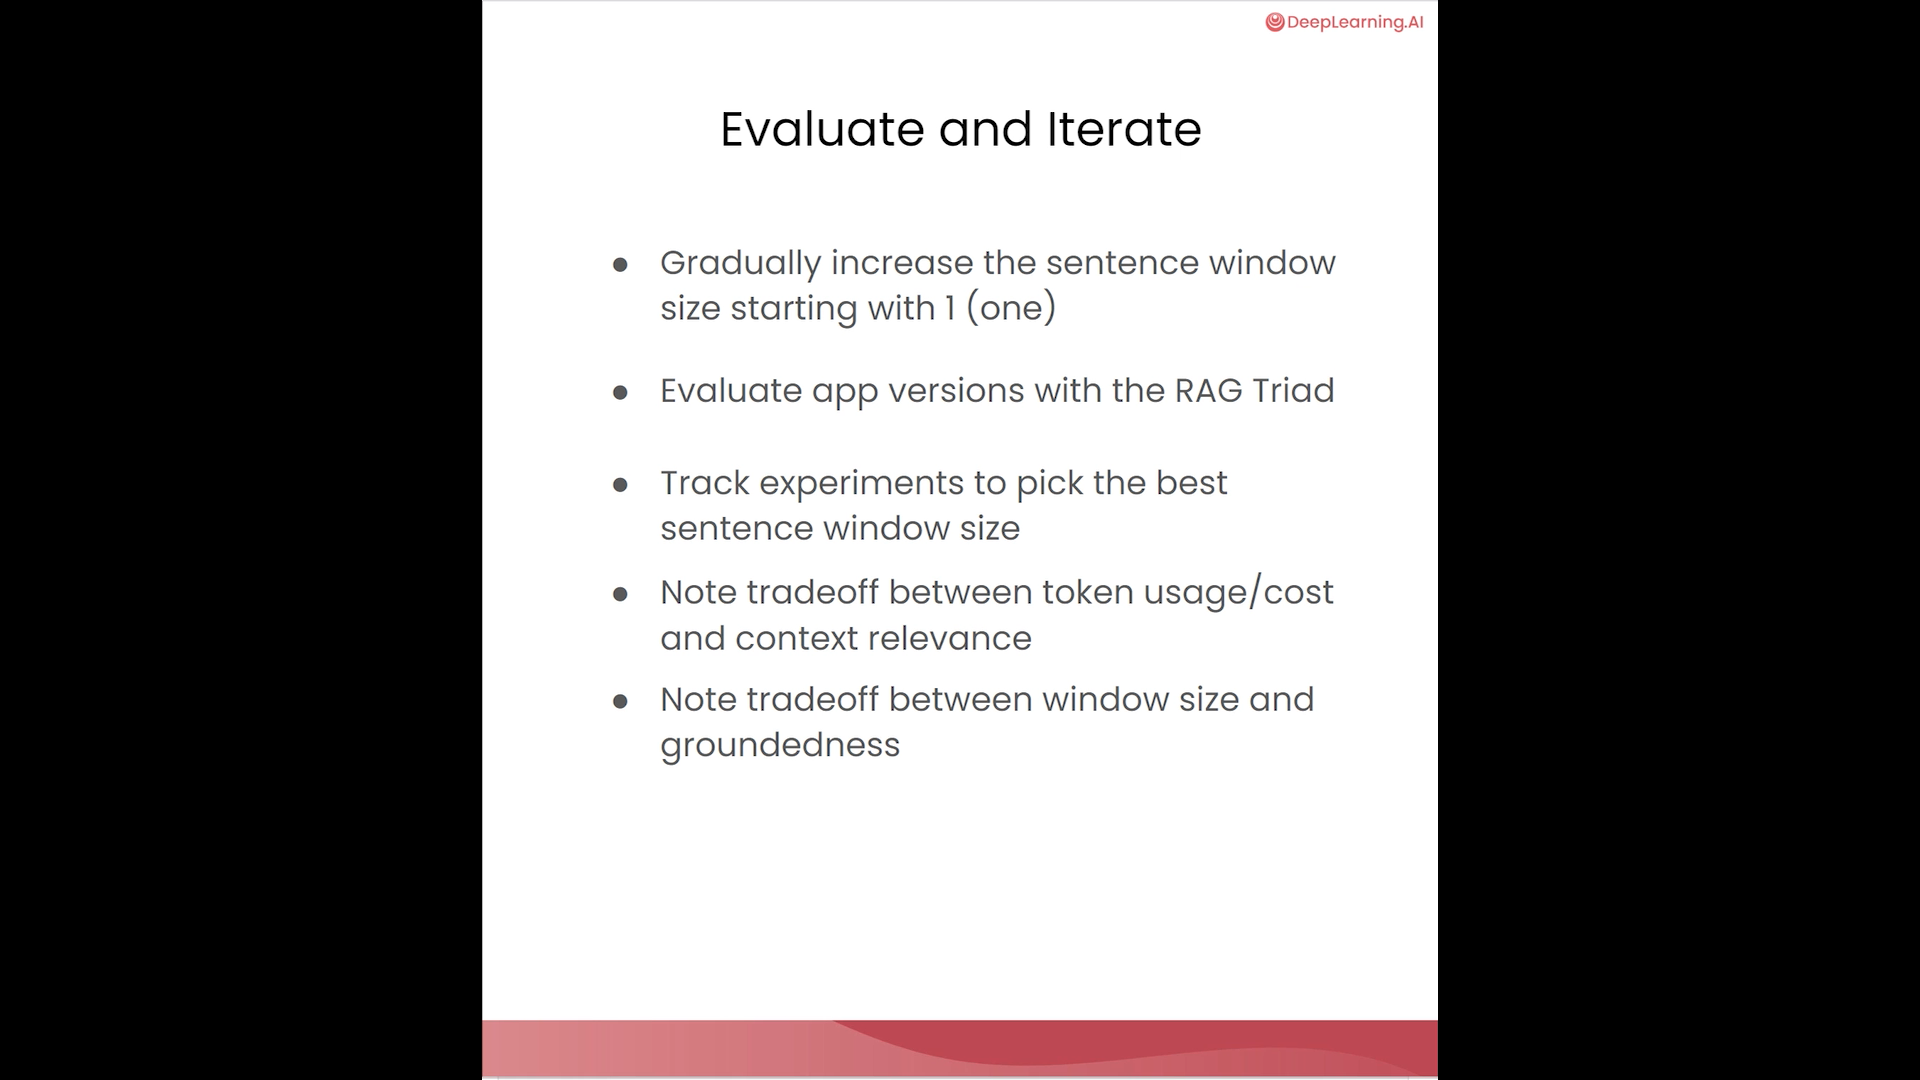

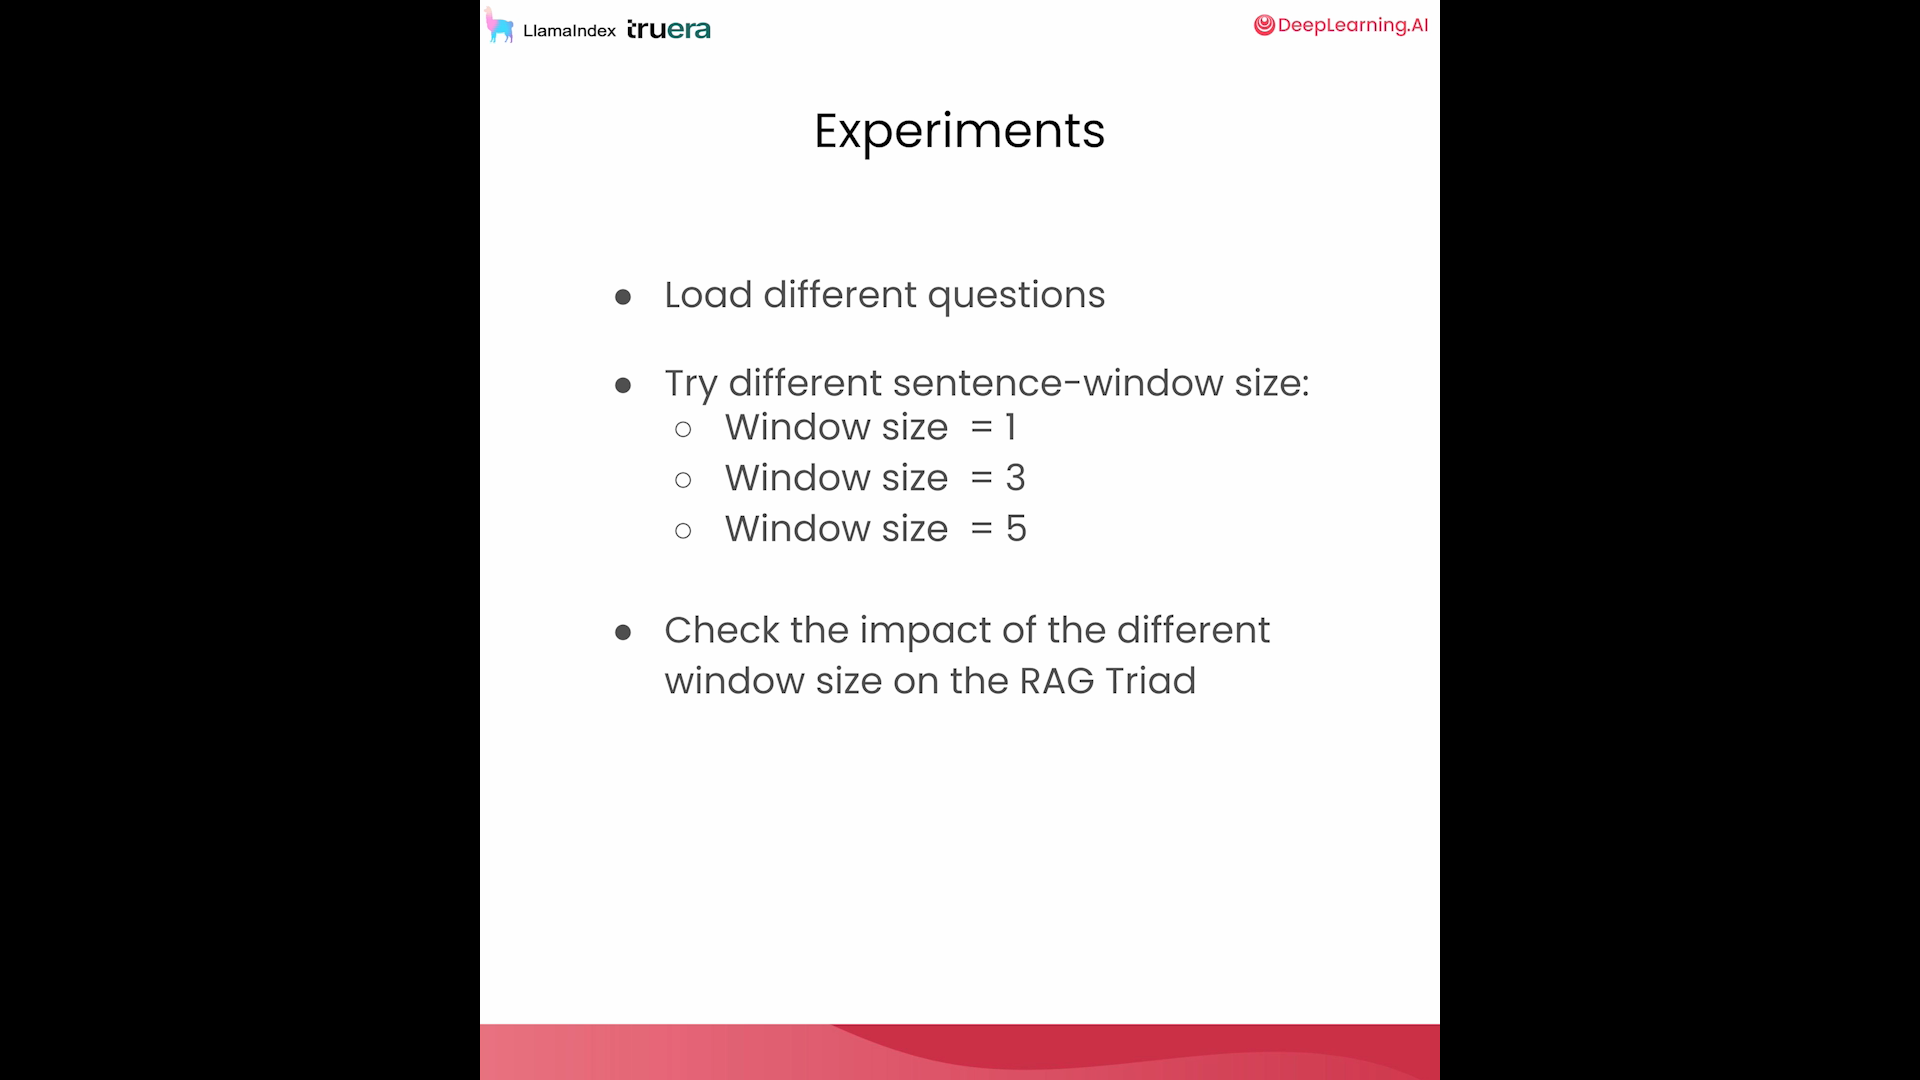

In [38]:
eval_questions = []
with open('generated_questions.text', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        eval_questions.append(item)

In [39]:
from trulens_eval import Tru

def run_evals(eval_questions, tru_recorder, query_engine):
    for question in eval_questions:
        with tru_recorder as recording:
            response = query_engine.query(question)

In [40]:
from utils import get_prebuilt_trulens_recorder

from trulens_eval import Tru

Tru().reset_database()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


### Sentence window size = 1

In [41]:
sentence_index_1 = build_sentence_window_index(
    documents,
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-small-en-v1.5",
    sentence_window_size=1,
    save_dir="sentence_index_1",
)

In [42]:
sentence_window_engine_1 = get_sentence_window_query_engine(
    sentence_index_1
)

In [43]:
tru_recorder_1 = get_prebuilt_trulens_recorder(
    sentence_window_engine_1,
    app_id='sentence window engine 1'
)

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [44]:
run_evals(eval_questions, tru_recorder_1, sentence_window_engine_1)

In [45]:
Tru().run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at https://s172-31-7-241p20547.lab-aws-production.deeplearning.ai/ .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

### Note about the dataset of questions
- Since this evaluation process takes a long time to run, the following file `generated_questions.text` contains one question (the one mentioned in the lecture video).
- If you would like to explore other possible questions, feel free to explore the file directory by clicking on the "Jupyter" logo at the top right of this notebook. You'll see the following `.text` files:

> - `generated_questions_01_05.text`
> - `generated_questions_06_10.text`
> - `generated_questions_11_15.text`
> - `generated_questions_16_20.text`
> - `generated_questions_21_24.text`

Note that running an evaluation on more than one question can take some time, so we recommend choosing one of these files (with 5 questions each) to run and explore the results.

- For evaluating a personal project, an eval set of 20 is reasonable.
- For evaluating business applications, you may need a set of 100+ in order to cover all the use cases thoroughly.
- Note that since API calls can sometimes fail, you may occasionally see null responses, and would want to re-run your evaluations.  So running your evaluations in smaller batches can also help you save time and cost by only re-running the evaluation on the batches with issues.

In [46]:
eval_questions = []
with open('generated_questions.text', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        eval_questions.append(item)

### Sentence window size = 3

In [47]:
sentence_index_3 = build_sentence_window_index(
    documents,
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-small-en-v1.5",
    sentence_window_size=3,
    save_dir="sentence_index_3",
)
sentence_window_engine_3 = get_sentence_window_query_engine(
    sentence_index_3
)

tru_recorder_3 = get_prebuilt_trulens_recorder(
    sentence_window_engine_3,
    app_id='sentence window engine 3'
)

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [48]:
run_evals(eval_questions, tru_recorder_3, sentence_window_engine_3)

In [49]:
Tru().run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.
Dashboard already running at path: https://s172-31-7-241p20547.lab-aws-production.deeplearning.ai/


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

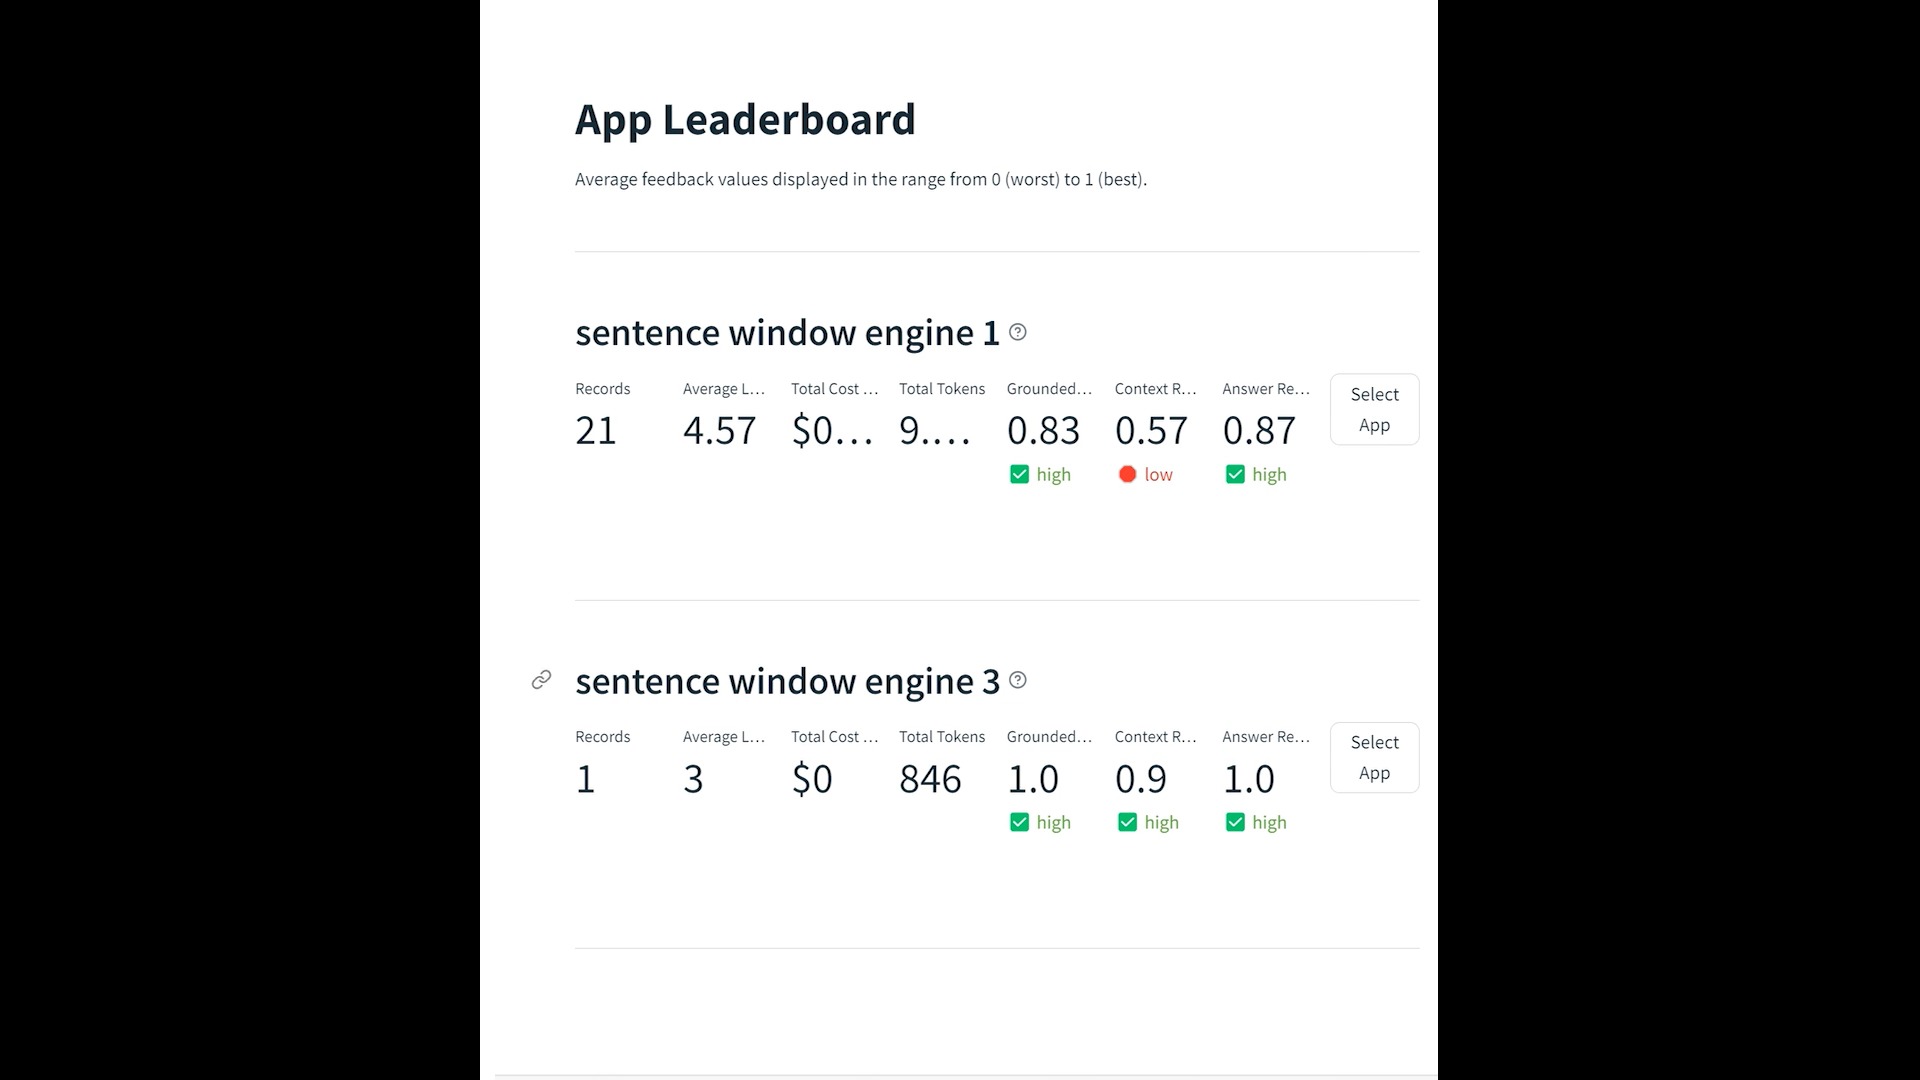

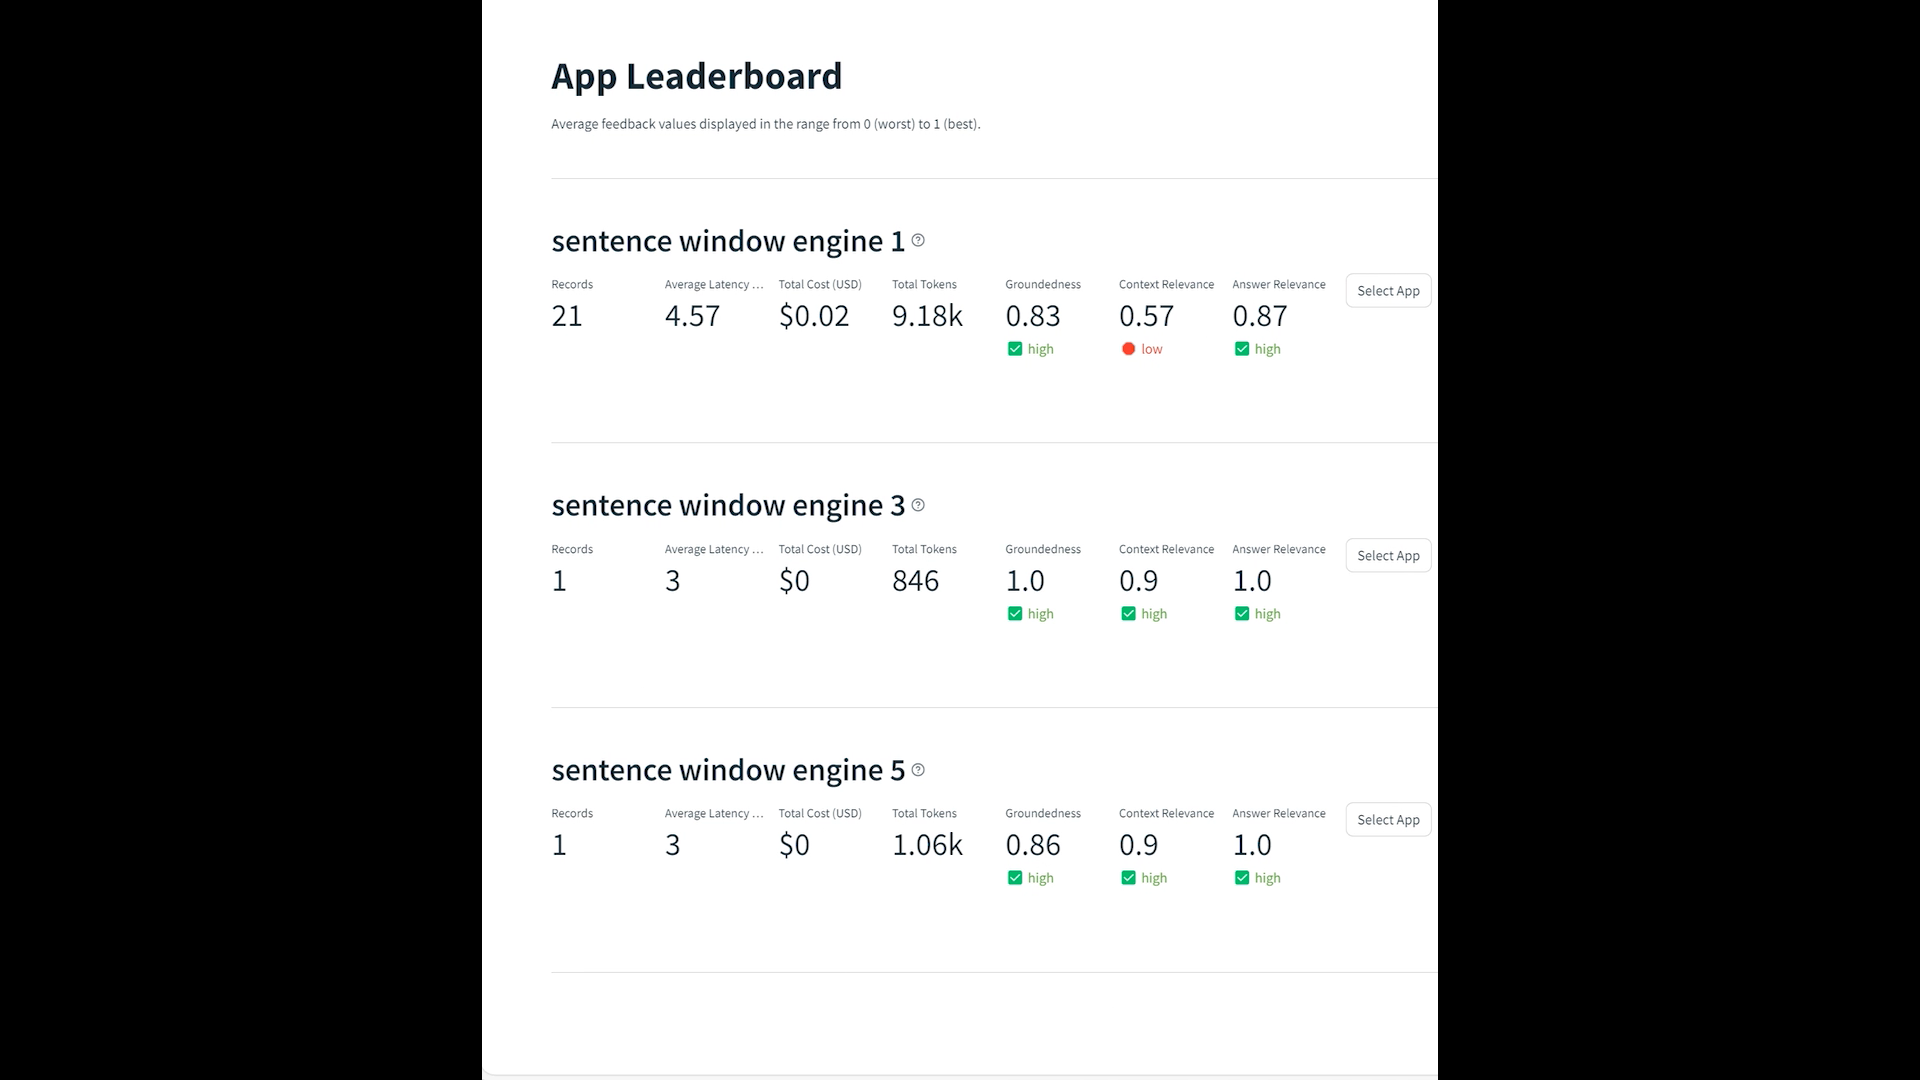